<a href="https://colab.research.google.com/github/xAn-x/Football-Shootout-Analysis/blob/master/Team_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements
- Divide the crops into teams based on their joursey-color

## Plan
1. Create Image Embeddings using SigLip Model
2. Dimensionality Reduction using uMap
3. K-means for divinding the emmbeddings into 2 cluster (1 for each team)


In [1]:
!pip install supervision umap-learn ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import supervision as sv
from ultralytics import YOLO

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# YOLO MODEL
!gdown https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4

Downloading...
From (original): https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4
From (redirected): https://drive.google.com/uc?id=1WosrbYsPjJ6DLq1Izd-dOWOj4D8njwL4&confirm=t&uuid=97936508-858b-4a72-b006-2becb6c9b92f
To: /content/last.pt
100% 40.5M/40.5M [00:01<00:00, 28.5MB/s]


In [4]:
# Video FIles
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 56.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 43.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 61.4MB/s]


In [5]:
yolo=YOLO("last.pt")

In [9]:
def get_crops(video_path,stride=30,image_name_pattern="image_{:05d}.png"):
  video_info=sv.VideoInfo.from_video_path(video_path)
  frame_generator=sv.get_video_frames_generator(video_path,stride=stride)
  crops=[]
  for i,frame in tqdm(enumerate(frame_generator),desc=f"generating crops for {video_path}",total=video_info.total_frames//stride):
    results=yolo.predict(frame,verbose=False)[0]
    detections=sv.Detections.from_ultralytics(results)
    detections=detections.with_nms(threshold=0.5,class_agnostic=True)

    players=detections[detections.class_id==2]
    temp_frame=frame

    if len(players)>0:
      crops+=[
          sv.crop_image(temp_frame,player[0]) for player in players
      ]
  return crops


In [10]:
from functools import reduce

video_files=["/content/08fd33_0.mp4","/content/0bfacc_0.mp4","/content/121364_0.mp4","/content/2e57b9_0.mp4","/content/573e61_0.mp4"]
# video_files=["/content/573e61_0.mp4"]

player_crops=list(map(get_crops,video_files))
player_crops=list(reduce(lambda x,y:x+y,player_crops))


generating crops for /content/573e61_0.mp4: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


In [11]:
len(player_crops)

2408

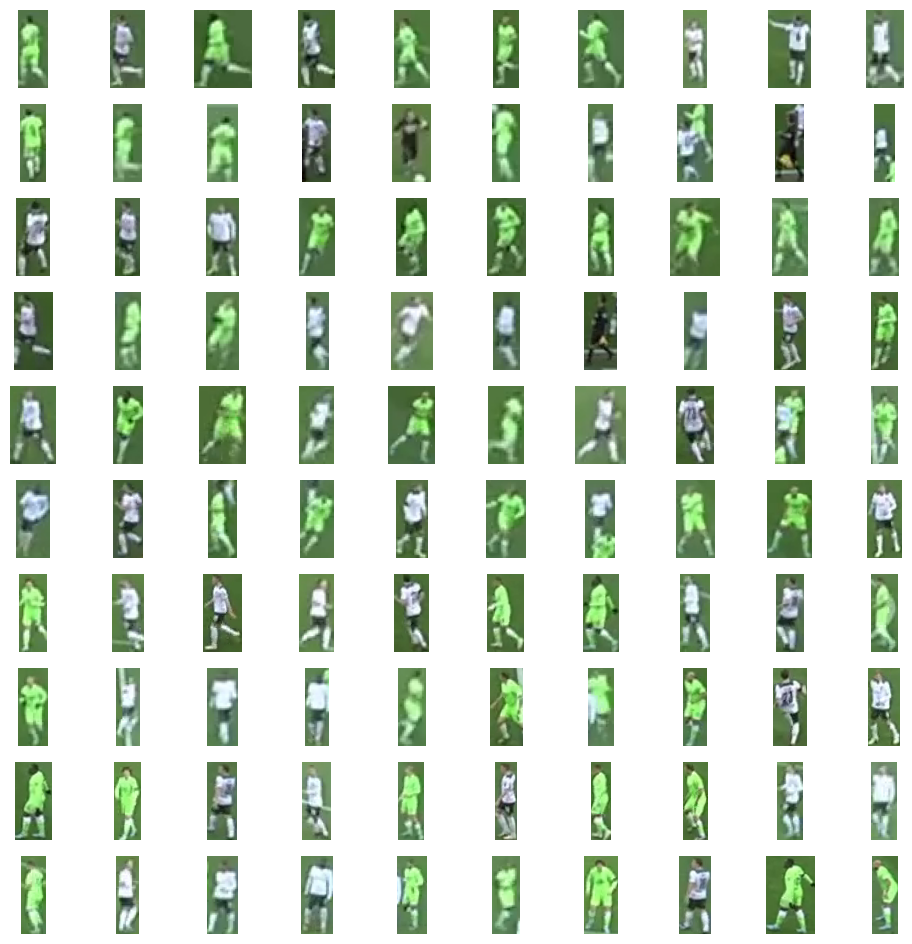

In [12]:
sv.plot_images_grid(player_crops[:100],(10,10))

## SigLip

In [13]:
from transformers import AutoProcessor,AutoModel
from torchsummary import summary

embeddings_model_config=r"google/siglip-base-patch16-224"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_PROCESSOR=AutoProcessor.from_pretrained(embeddings_model_config)
EMBEDDINGS_MODEL=AutoModel.from_pretrained(embeddings_model_config).to(DEVICE)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

In [14]:
DEVICE

'cuda'

In [16]:
# Siglip requires img in PIL format
pillow_player_crops=list(map(sv.cv2_to_pillow,player_crops))

from more_itertools import chunked
batch_size=128
batches=list(chunked(pillow_player_crops,batch_size))

data=[]
with torch.no_grad():
  for batch in tqdm(batches, desc='Siglip image embedding extraction'):
    inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)

    # Extract image features
    image_embeddings = EMBEDDINGS_MODEL.get_image_features(**inputs)
    data.append(image_embeddings.cpu().numpy())

data=np.concatenate(data)

Siglip image embedding extraction: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]


In [17]:
data.shape

(2408, 768)

## Using umap and kmean :
- umap for dimensionality reduction to get only features that explain most variance
- kmeans to divide teams into 2 cluster based on embeddings

In [18]:
import umap.umap_ as umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3, random_state=42)
CLUSTERING_MODEL = KMeans(n_clusters=2,random_state=42)

In [19]:
reduced_embedding=REDUCER.fit_transform(data)
output=CLUSTERING_MODEL.fit_predict(reduced_embedding)

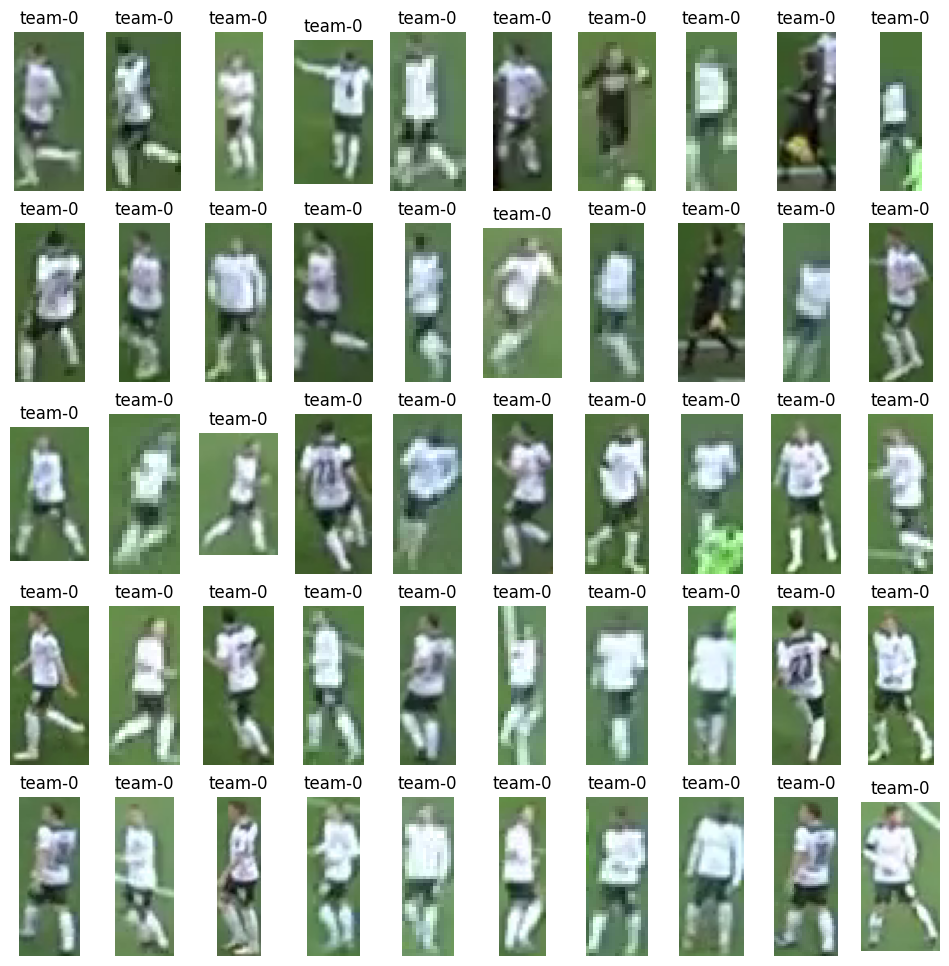

In [27]:
# Team-0
team_0_indices = [i for i, o in enumerate(output) if o == 0]
team_0_crops = [player_crops[i] for i in team_0_indices]

sv.plot_images_grid(team_0_crops[:50],grid_size=(5,10),titles=["team-0"]*50)

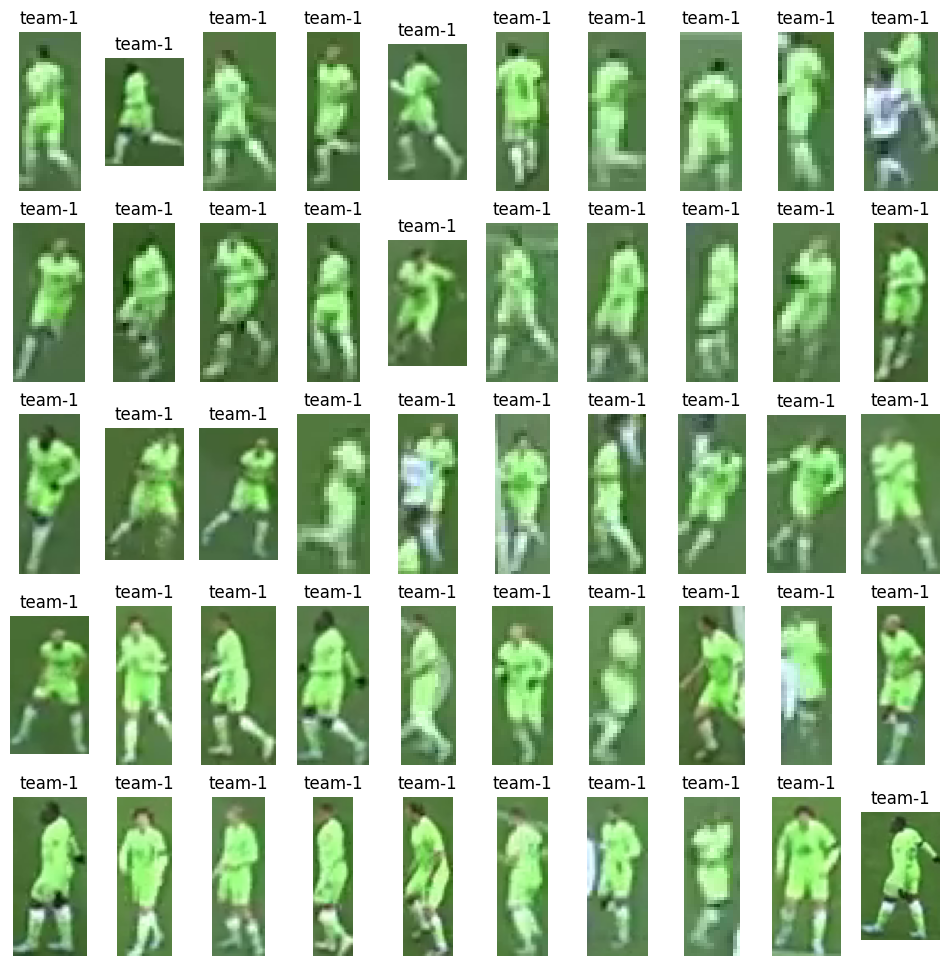

In [29]:
team_1_indices = [i for i, o in enumerate(output) if o == 1]
team_1_crops = [player_crops[i] for i in team_1_indices]

# Display images in a grid
sv.plot_images_grid(team_1_crops[:50],grid_size=(5,10),titles=["team-1"]*50)  # Adjust grid size as needed
plt.show()

In [30]:
import joblib

joblib.dump(CLUSTERING_MODEL, 'CLUSTERING_MODEL.pkl')
joblib.dump(REDUCER, 'REDUCER.pkl')

['REDUCER.pkl']

In [31]:
from google.colab import files

files.download('CLUSTERING_MODEL.pkl')
files.download('REDUCER.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>